In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install fanalysis

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# noms des variables de notre dataset y compris la variable identifiant IRIS
colonnes =["IDENT","TypeHabi", "GeoFaz_Scl", "GeoFaz_cl","Anciennete","Doublon_ligne",
            "Revenus_iris","Sexe","Prenom_Phase_scl_H", "Prenom_Phase_scl_F","Prenom_Phase_cl_H",
           "Prenom_Phase_cl_F","Age_H","Age_F","Pays_sud","Prenom_effectif","codif_RdB","Flag_PA",
           "Annee_1er_don","Cumul_dons","Don_max","Don_moyen","Vingtiles_ISF","IFI+"]

In [29]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''
#/content/drive/MyDrive/Stage_methods_spad/data_excel_2.csv
data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/my_data_FDFIFI19.txt",delim_whitespace="\t" , header = None, names=colonnes, low_memory=False, )#, dtype='Int64')

In [30]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(484522, 24)

In [31]:
# visualisation des premiers lignes
data.head()

,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,Anciennete,Doublon_ligne,Revenus_iris,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Pays_sud,Prenom_effectif,codif_RdB,Flag_PA,Annee_1er_don,Cumul_dons,Don_max,Don_moyen,Vingtiles_ISF,IFI+
0,101001347,3,75,7,8,3,3,3,64,46,6,4,9,4,2,3,3,2,7,7,6,4,10,2.0
1,201001512,1,74,7,5,3,3,4,65,81,6,8,11,12,2,4,3,2,8,5,2,2,10,2.0
2,301002801,2,32,3,7,2,4,4,66,66,6,6,11,9,2,3,3,2,8,7,5,3,7,2.0
3,401003186,1,12,1,4,3,7,3,51,81,5,8,9,12,2,5,1,2,2,7,8,6,18,2.0
4,501003624,2,12,1,6,3,3,3,51,81,5,8,9,12,2,5,1,2,8,7,8,6,2,2.0


In [32]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j+1])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j+1])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i+1])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0


def evaluation(model, X_train, y_train, X_test, y_test, scoring):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train))) # ajouter 
    print(classification_report(y_train, model.predict(X_train) ))

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 10) )

    plt.figure(figsize = (10,6))
    plt.plot(N, train_score.mean(axis=1), label ="train_score")
    plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")

    plt.legend()


In [33]:
# élimination des individus n'ayant pas de valeurs pour la variable IFI+
"""IMPORTANT"""
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]


In [34]:
#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [35]:
data = data_sans_nan

In [36]:
data["IFI+"].value_counts()

2    462833
1      2620
Name: IFI+, dtype: int64

In [37]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV

In [65]:
#####################################################################################
####################################################################################

In [14]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
# numéro correspondant à la dernière colonne
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [ ]:
model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = "balanced"), random_state =0 )
param = {'base_estimator__criterion': ['gini','entropy'], 'base_estimator__max_depth' : list(range(2,20, 2)), 'n_estimators' : [10,20,30,40,50] }

grid_AdaBoost = GridSearchCV(model_AdaBoost, param, cv = 4, scoring = "recall")
resultat_grid_AdaBoost = grid_AdaBoost.fit(train_X_s, train_Y_s)
resultat_grid_AdaBoost.best_params_
#model_AdaBoost.get_params



test set : 
[[  410    88]
 [ 9891 82702]]
              precision    recall  f1-score   support

           1       0.04      0.82      0.08       498
           2       1.00      0.89      0.94     92593

    accuracy                           0.89     93091
   macro avg       0.52      0.86      0.51     93091
weighted avg       0.99      0.89      0.94     93091

train set : 
[[  1797    325]
 [ 39111 331129]]
              precision    recall  f1-score   support

           1       0.04      0.85      0.08      2122
           2       1.00      0.89      0.94    370240

    accuracy                           0.89    372362
   macro avg       0.52      0.87      0.51    372362
weighted avg       0.99      0.89      0.94    372362



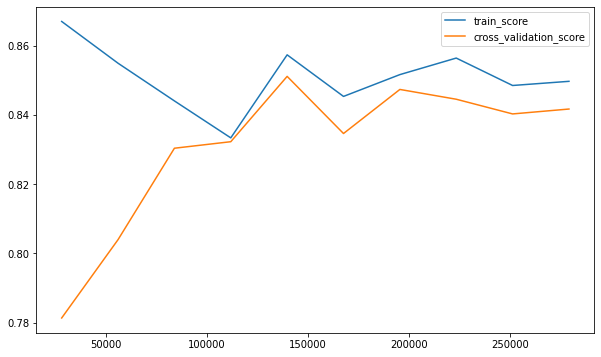

In [ ]:
final_model_AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(class_weight="balanced", criterion="gini",max_depth=2),n_estimators = 10 , random_state=0 ) 
evaluation(final_model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [ ]:
##################################################################
##################################################################

In [37]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,19)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 7,
 'min_samples_split': 0.1}

test set : 
[[  385   113]
 [43574 49019]]
              precision    recall  f1-score   support

           1       0.01      0.77      0.02       498
           2       1.00      0.53      0.69     92593

    accuracy                           0.53     93091
   macro avg       0.50      0.65      0.35     93091
weighted avg       0.99      0.53      0.69     93091

train set : 
[[  1609    513]
 [174487 195753]]
              precision    recall  f1-score   support

           1       0.01      0.76      0.02      2122
           2       1.00      0.53      0.69    370240

    accuracy                           0.53    372362
   macro avg       0.50      0.64      0.35    372362
weighted avg       0.99      0.53      0.69    372362



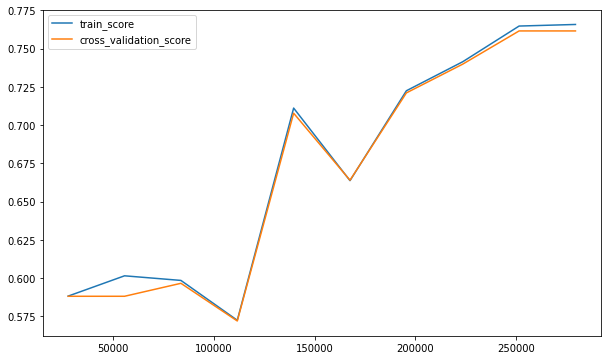

In [38]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [39]:

# importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
1,GeoFaz_Scl,0.651813
17,Vingtiles_ISF,0.199837
7,Prenom_Phase_scl_H,0.148350
10,Prenom_Phase_cl_F,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000
14,Prenom_effectif,0.000000
13,Pays_sud,0.000000
12,Age_F,0.000000
11,Age_H,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Vingtiles_ISF <= 15.5\ngini = 0.467\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'gini = 0.431\nsamples = 196266\nvalue = [45009.827, 98437.471]'),
 Text(313.875, 90.59999999999997, 'gini = 0.495\nsamples = 41027\nvalue = [25180.936, 20486.749]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_H <= 55.5\ngini = 0.465\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'gini = 0.406\nsamples = 55652\nvalue = [69752.071, 27585.704]'),
 Text(732.375, 90.59999999999997, 'gini = 0.497\nsamples = 79417\nvalue = [46238.165, 39671.076]')]

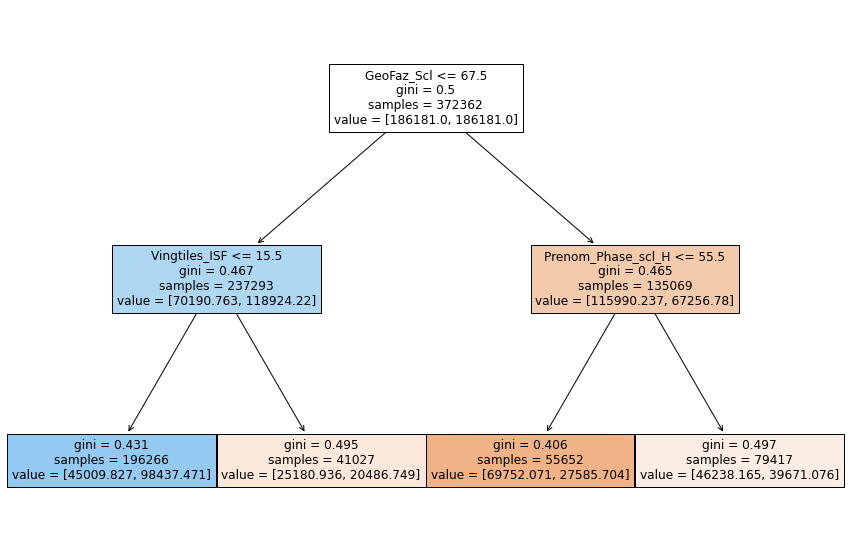

In [40]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################

In [15]:
# on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Don_moyen"],axis=1)


In [27]:
# base de données avec des variables corrélées et sans encodage OneHot


train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [31]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_


{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 9,
 'min_samples_split': 0.1}

test set : 
[[  417    81]
 [12540 80053]]
              precision    recall  f1-score   support

           1       0.03      0.84      0.06       498
           2       1.00      0.86      0.93     92593

    accuracy                           0.86     93091
   macro avg       0.52      0.85      0.49     93091
weighted avg       0.99      0.86      0.92     93091

train set : 
[[  1828    294]
 [ 50227 320013]]
              precision    recall  f1-score   support

           1       0.04      0.86      0.07      2122
           2       1.00      0.86      0.93    370240

    accuracy                           0.86    372362
   macro avg       0.52      0.86      0.50    372362
weighted avg       0.99      0.86      0.92    372362



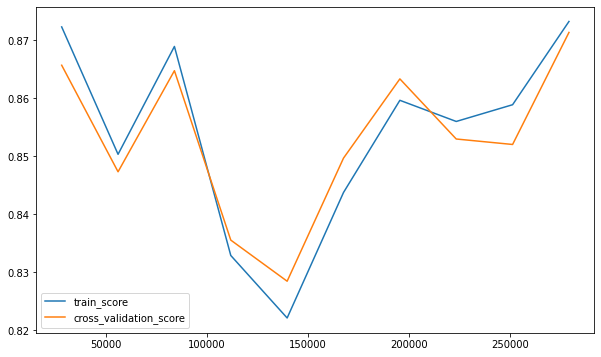

In [32]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 8, max_features=9, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [33]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
18,Cumul_dons,0.669001
19,Don_max,0.298596
5,Revenus_iris,0.013495
20,Vingtiles_ISF,0.010643
1,GeoFaz_Scl,0.002385
4,Doublon_ligne,0.002374
2,GeoFaz_cl,0.001567
6,Sexe,0.000941
7,Prenom_Phase_scl_H,0.000686
12,Age_F,0.000313


[Text(642.9130434782609, 513.4, 'Cumul_dons <= 5.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(545.8695652173913, 453.0, 'Don_max <= 6.5\ngini = 0.36\nsamples = 329300\nvalue = [50976.042, 165301.513]'),
 Text(497.3478260869565, 392.6, 'Don_max <= 5.5\ngini = 0.249\nsamples = 308676\nvalue = [26409.275, 155071.213]'),
 Text(363.9130434782609, 332.2, 'Vingtiles_ISF <= 19.5\ngini = 0.173\nsamples = 251748\nvalue = [13336.245, 126519.001]'),
 Text(315.39130434782606, 271.8, 'Doublon_ligne <= 2.5\ngini = 0.152\nsamples = 245526\nvalue = [11142.784, 123402.742]'),
 Text(194.08695652173913, 211.39999999999998, 'GeoFaz_Scl <= 71.5\ngini = 0.214\nsamples = 90712\nvalue = [6317.169, 45579.748]'),
 Text(145.56521739130434, 151.0, 'Revenus_iris <= 7.5\ngini = 0.17\nsamples = 69176\nvalue = [3597.277, 34765.621]'),
 Text(97.04347826086956, 90.59999999999997, 'Sexe <= 2.5\ngini = 0.167\nsamples = 69147\nvalue = [3509.538, 34751.541]'),
 Text(48.52173913043478, 30.1999999999

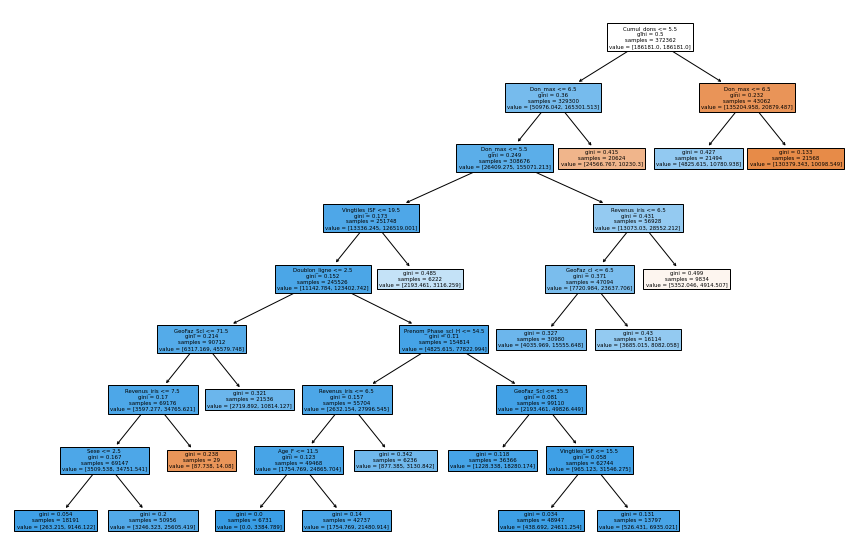

In [34]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################

In [16]:
# on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Annee_1er_don", "Cumul_dons","Don_max"],axis=1)


In [17]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [37]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 7,
 'min_samples_split': 0.1}

test set : 
[[  418    80]
 [11971 80622]]
              precision    recall  f1-score   support

           1       0.03      0.84      0.06       498
           2       1.00      0.87      0.93     92593

    accuracy                           0.87     93091
   macro avg       0.52      0.86      0.50     93091
weighted avg       0.99      0.87      0.93     93091

train set : 
[[  1816    306]
 [ 47706 322534]]
              precision    recall  f1-score   support

           1       0.04      0.86      0.07      2122
           2       1.00      0.87      0.93    370240

    accuracy                           0.87    372362
   macro avg       0.52      0.86      0.50    372362
weighted avg       0.99      0.87      0.93    372362



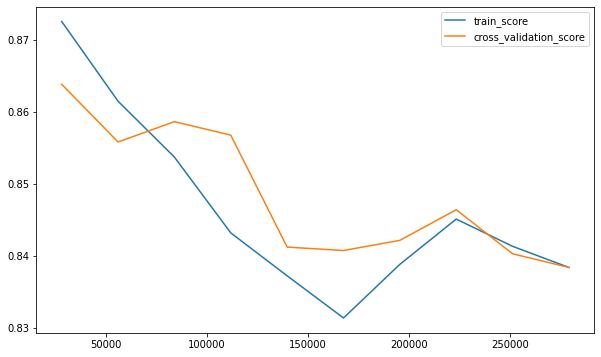

In [22]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="gini", class_weight = "balanced", max_depth = 2, max_features=7, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [32]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
1,GeoFaz_Scl,0.651813
17,Vingtiles_ISF,0.199837
7,Prenom_Phase_scl_H,0.148350
10,Prenom_Phase_cl_F,0.000000
16,Flag_PA,0.000000
15,codif_RdB,0.000000
14,Prenom_effectif,0.000000
13,Pays_sud,0.000000
12,Age_F,0.000000
11,Age_H,0.000000


[Text(418.5, 453.0, 'GeoFaz_Scl <= 67.5\ngini = 0.5\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(209.25, 271.8, 'Vingtiles_ISF <= 15.5\ngini = 0.467\nsamples = 237293\nvalue = [70190.763, 118924.22]'),
 Text(104.625, 90.59999999999997, 'gini = 0.431\nsamples = 196266\nvalue = [45009.827, 98437.471]'),
 Text(313.875, 90.59999999999997, 'gini = 0.495\nsamples = 41027\nvalue = [25180.936, 20486.749]'),
 Text(627.75, 271.8, 'Prenom_Phase_scl_H <= 55.5\ngini = 0.465\nsamples = 135069\nvalue = [115990.237, 67256.78]'),
 Text(523.125, 90.59999999999997, 'gini = 0.406\nsamples = 55652\nvalue = [69752.071, 27585.704]'),
 Text(732.375, 90.59999999999997, 'gini = 0.497\nsamples = 79417\nvalue = [46238.165, 39671.076]')]

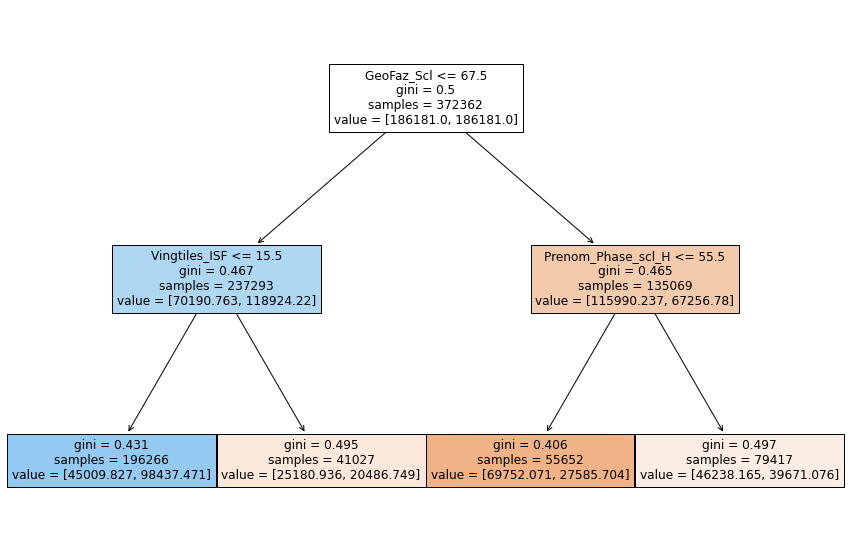

In [33]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [ ]:
##################################################################
##################################################################
##################################################################

In [38]:
# éliminer les variables corrélées
# tableau de corrélation 
tableau_corr =data_sans_nan.iloc[:,1:23].corr()
variables_corr(tableau_corr, 0.95)


variable :  GeoFaz_Scl
corr pos ['GeoFaz_cl']
corr pos [1.0]

variable :  Prenom_Phase_scl_H
corr pos ['Prenom_Phase_cl_H']
corr pos [0.99]

variable :  Prenom_Phase_scl_F
corr pos ['Prenom_Phase_cl_F']
corr pos [0.99]



In [39]:
 # éliminer les variables corrélées
data =  data.drop(["GeoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F"], axis = 1)


In [40]:
# base de données avec des variables corrélées et sans encodage OneHot

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [41]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,19)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 13,
 'min_samples_split': 0.1}

test set : 
[[  424    74]
 [13094 79499]]
              precision    recall  f1-score   support

           1       0.03      0.85      0.06       498
           2       1.00      0.86      0.92     92593

    accuracy                           0.86     93091
   macro avg       0.52      0.85      0.49     93091
weighted avg       0.99      0.86      0.92     93091

train set : 
[[  1840    282]
 [ 52460 317780]]
              precision    recall  f1-score   support

           1       0.03      0.87      0.07      2122
           2       1.00      0.86      0.92    370240

    accuracy                           0.86    372362
   macro avg       0.52      0.86      0.49    372362
weighted avg       0.99      0.86      0.92    372362



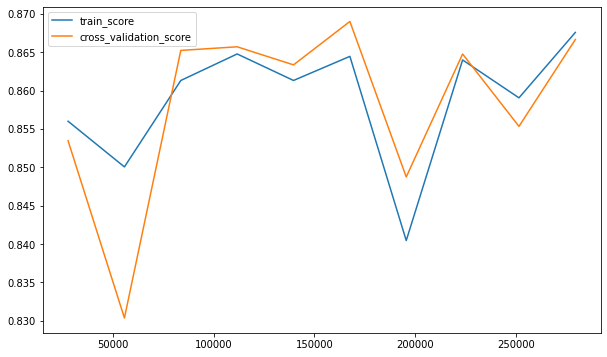

In [43]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, criterion="entropy", class_weight = "balanced", max_depth = 5, max_features=13, min_samples_split=0.1 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [44]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
16,Don_max,0.951853
18,Vingtiles_ISF,0.020641
4,Revenus_iris,0.011483
3,Doublon_ligne,0.008012
13,Flag_PA,0.005945
17,Don_moyen,0.002064
11,Prenom_effectif,0.000000
15,Cumul_dons,0.000000
14,Annee_1er_don,0.000000
12,codif_RdB,0.000000


[Text(571.9499999999999, 498.3, 'Don_max <= 6.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(418.5, 407.70000000000005, 'Don_max <= 5.5\nentropy = 0.631\nsamples = 330170\nvalue = [31234.89, 165852.151]'),
 Text(279.0, 317.1, 'Vingtiles_ISF <= 17.5\nentropy = 0.478\nsamples = 260834\nvalue = [15003.276, 131078.484]'),
 Text(223.2, 226.5, 'Doublon_ligne <= 2.5\nentropy = 0.4\nsamples = 232766\nvalue = [10089.922, 116992.21]'),
 Text(111.6, 135.89999999999998, 'Flag_PA <= 1.5\nentropy = 0.536\nsamples = 87772\nvalue = [6141.692, 44102.328]'),
 Text(55.8, 45.299999999999955, 'entropy = 0.968\nsamples = 3476\nvalue = [1140.6, 1741.424]'),
 Text(167.39999999999998, 45.299999999999955, 'entropy = 0.486\nsamples = 84296\nvalue = [5001.092, 42360.904]'),
 Text(334.79999999999995, 135.89999999999998, 'Vingtiles_ISF <= 14.5\nentropy = 0.292\nsamples = 144994\nvalue = [3948.23, 72889.882]'),
 Text(279.0, 45.299999999999955, 'entropy = 0.236\nsamples = 112609\nvalue = [2

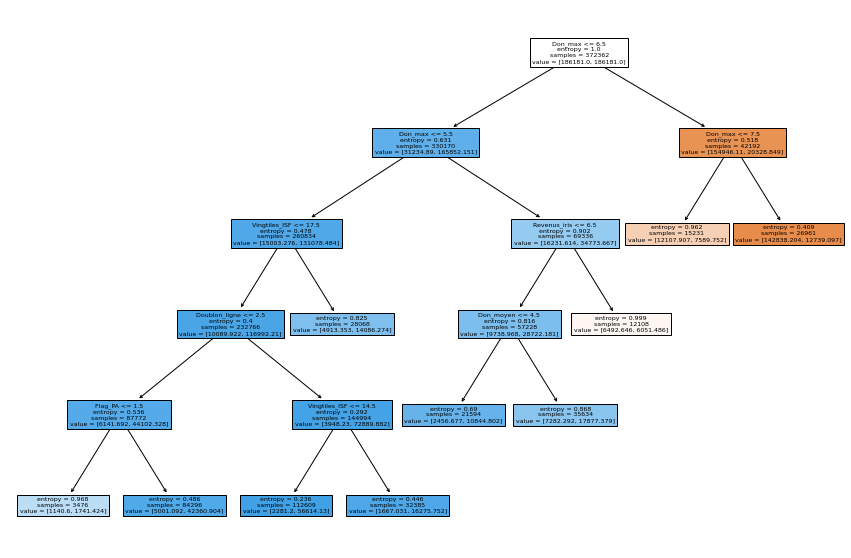

In [45]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [47]:
# on élimine la variable qui contribue le plus au modèle précédent
data=data.drop(["Don_moyen","Annee_1er_don", "Cumul_dons","Don_max"],axis=1)

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=0 )
nb_var = data.shape[1] - 1

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

In [49]:

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0, class_weight = "balanced" )
param = { 'max_depth' :list(range(2,30)), 'criterion': ["gini", "entropy"], 'max_features' : list(range(5,15)),
         'min_samples_split' : np.linspace(0.1, 1.0, 5) }

grid_DecisionTreeClassifier = GridSearchCV(model_DecisionTreeClassifier, param_grid= param, cv = 4, scoring = "recall")
resultat_grid_DecisionTreeClassifier = grid_DecisionTreeClassifier.fit(train_X_s, train_Y_s)
resultat_grid_DecisionTreeClassifier.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 8,
 'min_samples_split': 0.325}

test set : 
[[  367   131]
 [39021 53572]]
              precision    recall  f1-score   support

           1       0.01      0.74      0.02       498
           2       1.00      0.58      0.73     92593

    accuracy                           0.58     93091
   macro avg       0.50      0.66      0.38     93091
weighted avg       0.99      0.58      0.73     93091

train set : 
[[  1518    604]
 [155796 214444]]
              precision    recall  f1-score   support

           1       0.01      0.72      0.02      2122
           2       1.00      0.58      0.73    370240

    accuracy                           0.58    372362
   macro avg       0.50      0.65      0.38    372362
weighted avg       0.99      0.58      0.73    372362



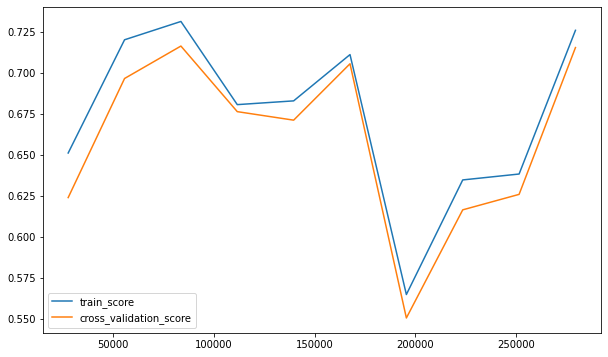

In [51]:
final_model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 0,class_weight = "balanced", criterion="entropy", max_depth = 3, max_features = 8, min_samples_split=0.325 )
evaluation(final_model_DecisionTreeClassifier, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring="recall" )

In [52]:

#importance des variables
impVarFirst={"Variable":data.columns[1:-1],"Importance":final_model_DecisionTreeClassifier.feature_importances_}
pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)

,Variable,Importance
4,Revenus_iris,0.765341
1,GeoFaz_Scl,0.151920
6,Prenom_Phase_scl_H,0.082739
0,TypeHabi,0.000000
2,Anciennete,0.000000
3,Doublon_ligne,0.000000
5,Sexe,0.000000
7,Prenom_Phase_scl_F,0.000000
8,Age_H,0.000000
9,Age_F,0.000000


[Text(558.0, 475.65000000000003, 'Revenus_iris <= 6.5\nentropy = 1.0\nsamples = 372362\nvalue = [186181.0, 186181.0]'),
 Text(418.5, 339.75, 'GeoFaz_Scl <= 67.5\nentropy = 0.97\nsamples = 318574\nvalue = [105373.884, 159595.999]'),
 Text(279.0, 203.85000000000002, 'Prenom_Phase_scl_H <= 65.5\nentropy = 0.914\nsamples = 215048\nvalue = [52994.026, 107836.534]'),
 Text(139.5, 67.94999999999999, 'entropy = 0.962\nsamples = 127219\nvalue = [40008.735, 63744.766]'),
 Text(418.5, 67.94999999999999, 'entropy = 0.774\nsamples = 87829\nvalue = [12985.291, 44091.768]'),
 Text(558.0, 203.85000000000002, 'entropy = 1.0\nsamples = 103526\nvalue = [52379.857, 51759.465]'),
 Text(697.5, 339.75, 'entropy = 0.807\nsamples = 53788\nvalue = [80807.116, 26585.001]')]

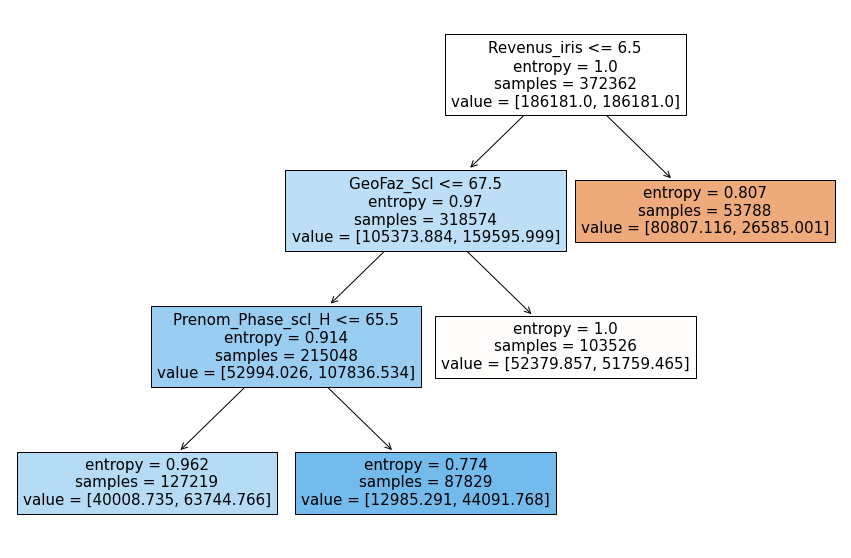

In [53]:
# affichage graphique de l'arbre (il faut vérifier les noms des colonnes pour qu'on affiche correctement l'arbre)

plt.figure(figsize = (15, 10))
plot_tree(final_model_DecisionTreeClassifier,feature_names = list(data.columns[1:-1]),filled=True)



In [35]:
#model_AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight = { 1 : 178, 2 : 1 }), n_estimators=50, random_state =0 )
#evaluation(model_AdaBoost, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "recall")

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_Y_s),
                                                 train_Y_s)
class_weights

array([87.73845429,  0.50286571])

In [ ]:
 462833/2620

176.65381679389313

In [ ]:
1/0.50286571

1.988602483951431

In [ ]:
87.73845429*1.988602483951431

174.4769081391531

In [ ]:
np.linspace(0.1, 1.0, 5)#, endpoint=True) 

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])